# Project: Train a Quadcopter How to Fly

Design an agent that can fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

![Quadcopter doing a flip trying to takeoff from the ground](images/quadcopter_tumble.png)

## Instructions

> **Note**: If you haven't done so already, follow the steps in this repo's README to install ROS, and ensure that the simulator is running and correctly connecting to ROS.

When you are ready to start coding, take a look at the `quad_controller_rl/src/` (source) directory to better understand the structure. Here are some of the salient items:

- `src/`: Contains all the source code for the project.
  - `quad_controller_rl/`: This is the root of the Python package you'll be working in.
  - ...
  - `tasks/`: Define your tasks (environments) in this sub-directory.
    - `__init__.py`: When you define a new task, you'll have to import it here.
    - `base_task.py`: Generic base class for all tasks, with documentation.
    - `takeoff.py`: This is the first task, already defined for you, and set to run by default.
  - ...
  - `agents/`: Develop your reinforcement learning agents here.
    - `__init__.py`: When you define a new agent, you'll have to import it here, just like tasks.
    - `base_agent.py`: Generic base class for all agents, with documentation.
    - `policy_search.py`: A sample agent has been provided here, and is set to run by default.
  - ...

### Tasks

Open up the base class for tasks, `BaseTask`, defined in `tasks/base_task.py`:

```python
class BaseTask:
    """Generic base class for reinforcement learning tasks."""

    def __init__(self):
        """Define state and action spaces, initialize other task parameters."""
        pass
    
    def set_agent(self, agent):
        """Set an agent to carry out this task; to be called from update."""
        self.agent = agent
    
    def reset(self):
        """Reset task and return initial condition."""
        raise NotImplementedError
    
    def update(self, timestamp, pose, angular_velocity, linear_acceleration):
        """Process current data, call agent, return action and done flag."""
        raise NotImplementedError            
```

All tasks must inherit from this class to function properly. You will need to override the `reset()` and `update()` methods when defining a task, otherwise you will get `NotImplementedError`'s. Besides these two, you should define the state (observation) space and the action space for the task in the constructor, `__init__()`, and initialize any other variables you may need to run the task.

Now compare this with the first concrete task `Takeoff`, defined in `tasks/takeoff.py`:

```python
class Takeoff(BaseTask):
    """Simple task where the goal is to lift off the ground and reach a target height."""
    ...
```

In `__init__()`, notice how the state and action spaces are defined using [OpenAI Gym spaces](https://gym.openai.com/docs/#spaces), like [`Box`](https://github.com/openai/gym/blob/master/gym/spaces/box.py). These objects provide a clean and powerful interface for agents to explore. For instance, they can inspect the dimensionality of a space (`shape`), ask for the limits (`high` and `low`), or even sample a bunch of observations using the `sample()` method, before beginning to interact with the environment. We also set a time limit (`max_duration`) for each episode here, and the height (`target_z`) that the quadcopter needs to reach for a successful takeoff.

The `reset()` method is meant to give you a chance to reset/initialize any variables you need in order to prepare for the next episode. You do not need to call it yourself; it will be invoked externally. And yes, it will be called once before each episode, including the very first one. Here `Takeoff` doesn't have any episode variables to initialize, but it must return a valid _initial condition_ for the task, which is a tuple consisting of a [`Pose`](http://docs.ros.org/api/geometry_msgs/html/msg/Pose.html) and [`Twist`](http://docs.ros.org/api/geometry_msgs/html/msg/Twist.html) object. These are ROS message types used to convey the pose (position, orientation) and velocity (linear, angular) you want the quadcopter to have at the beginning of an episode. You may choose to supply the same initial values every time, or change it a little bit, e.g. `Takeoff` drops the quadcopter off from a small height with a bit of randomness.

> **Tip**: Slightly randomized initial conditions can help the agent explore the state space faster.

Finally, the `update()` method is perhaps the most important. This is where you define the dynamics of the task and engage the agent. It is called by a ROS process periodically (roughly 30 times a second, by default), with current data from the simulation. A number of arguments are available: `timestamp` (you can use this to check for timeout, or compute velocities), `pose` (position, orientation of the quadcopter), `angular_velocity`, and `linear_acceleration`. You do not have to include all these variables in every task, e.g. `Takeoff` only uses pose information, and even that requires a 7-element state vector.

Once you have prepared the state you want to pass on to your agent, you will need to compute the reward, and check whether the episode is complete (e.g. agent crossed the time limit, or reached a certain height). Note that these two things (`reward` and `done`) are based on actions that the agent took in the past. When you are writing your own agents, you have to be mindful of this.

Now you can pass in the `state`, `reward` and `done` values to the agent's `step()` method and expect an action vector back that matches the action space that you have defined, in this case a `Box(6,)`. After checking that the action vector is non-empty, and clamping it to the space limits, you have to convert it into a ROS `Wrench` message. The first 3 elements of the action vector are interpreted as force in x, y, z directions, and the remaining 3 elements convey the torque to be applied around those axes, respectively.

Return the `Wrench` object (or `None` if you don't want to take any action) and the `done` flag from your `update()` method (note that when `done` is `True`, the `Wrench` object is ignored, so you can return `None` instead). This will be passed back to the simulation as a control command, and will affect the quadcopter's pose, orientation, velocity, etc. You will be able to gauge the effect when the `update()` method is called in the next time step.

### Agents

Reinforcement learning agents are defined in a similar way. Open up the generic agent class, `BaseAgent`, defined in `agents/base_agent.py`, and the sample agent `RandomPolicySearch` defined in `agents/policy_search.py`. They are actually even simpler to define - you only need to implement the `step()` method that is discussed above. It needs to consume `state` (vector), `reward` (scalar value) and `done` (boolean), and produce an `action` (vector). The state and action vectors must match the respective space indicated by the task. And that's it!

Well, that's just to get things working correctly! The sample agent given `RandomPolicySearch` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode ("score"), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

In [1]:
%%html
<div style="width: 100%; text-align: center;">
    <h3>Teach a Quadcopter How to Tumble</h3>
    <video poster="images/quadcopter_tumble.png" width="640" controls muted>
        <source src="images/quadcopter_tumble.mp4" type="video/mp4" />
        <p>Video: Quadcopter tumbling, trying to get off the ground</p>
    </video>
</div>

Obviously, this agent performs very poorly on the task. It does manage to move the quadcopter, which is good, but instead of a stable takeoff, it often leads to dizzying cartwheels and somersaults! And that's where you come in - your first _task_ is to design a better agent for this takeoff task. Instead of messing with the sample agent, create new file in the `agents/` directory, say `policy_gradients.py`, and define your own agent in it. Remember to inherit from the base agent class, e.g.:

```python
class DDPG(BaseAgent):
    ...
```

You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode_vars()`, etc.).

> **Note**: This setup may look similar to the common OpenAI Gym paradigm, but there is one small yet important difference. Instead of the agent calling a method on the environment (to execute an action and obtain the resulting state, reward and done value), here it is the task that is calling a method on the agent (`step()`). If you plan to store experience tuples for learning, you will need to cache the last state ($S_{t-1}$) and last action taken ($A_{t-1}$), then in the next time step when you get the new state ($S_t$) and reward ($R_t$), you can store them along with the `done` flag ($\left\langle S_{t-1}, A_{t-1}, R_t, S_t, \mathrm{done?}\right\rangle$).

When an episode ends, the agent receives one last call to the `step()` method with `done` set to `True` - this is your chance to perform any cleanup/reset/batch-learning (note that no reset method is called on an agent externally). The action returned on this last call is ignored, so you may safely return `None`. The next call would be the beginning of a new episode.

One last thing - in order to run your agent, you will have to edit `agents/__init__.py` and import your agent class in it, e.g.:

```python
from quad_controller_rl.agents.policy_gradients import DDPG
```

Then, while launching ROS, you will need to specify this class name on the commandline/terminal:

```bash
roslaunch quad_controller_rl rl_controller.launch agent:=DDPG
```

Okay, now the first task is cut out for you - follow the instructions below to implement an agent that learns to take off from the ground. For the remaining tasks, you get to define the tasks as well as the agents! Use the `Takeoff` task as a guide, and refer to the `BaseTask` docstrings for the different methods you need to override. Use some debug print statements to understand the flow of control better. And just like creating new agents, new tasks must inherit `BaseTask`, they need be imported into `tasks/__init__.py`, and specified on the commandline when running:

```bash
roslaunch quad_controller_rl rl_controller.launch task:=Hover agent:=DDPG
```

> **Tip**: You typically need to launch ROS and then run the simulator manually. But you can automate that process by either copying/symlinking your simulator to `quad_controller_rl/sim/DroneSim` (`DroneSim` must be an executable/link to one), or by specifying it on the command line, as follows:
> 
> ```bash
> roslaunch quad_controller_rl rl_controller.launch task:=Hover agent:=DDPG sim:=<full path>
> ```

## Task 1: Takeoff

### Implement takeoff agent

Train an agent to successfully lift off from the ground and reach a certain threshold height. Develop your agent in a file under `agents/` as described above, implementing at least the `step()` method, and any other supporting methods that might be necessary. You may use any reinforcement learning algorithm of your choice (note that the action space consists of continuous variables, so that may somewhat limit your choices).

The task has already been defined (in `tasks/takeoff.py`), which you should not edit. The default target height (Z-axis value) to reach is 10 units above the ground. And the reward function is essentially the negative absolute distance from that set point (upto some threshold). An episode ends when the quadcopter reaches the target height (x and y values, orientation, velocity, etc. are ignored), or when the maximum duration is crossed (5 seconds).  See `Takeoff.update()` for more details, including episode bonus/penalty.

As you develop your agent, it's important to keep an eye on how it's performing. Build in a mechanism to log/save the total rewards obtained in each episode to file. Once you are satisfied with your agent's performance, return to this notebook to plot episode rewards, and answer the questions below.

### Plot episode rewards

Plot the total rewards obtained in each episode, either from a single run, or averaged over multiple runs.

In [2]:
# TODO: Read and plot episode rewards
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

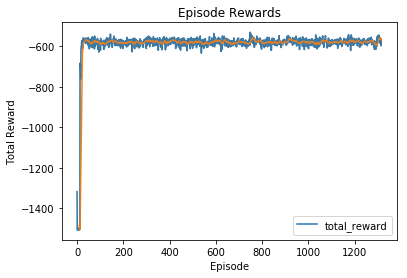

In [5]:
takeoff_stats = pd.read_csv("quad_controller_rl/1_takeoff/takeoff_final_1.csv")
takeoff_stats[['total_reward']].plot(title="Episode Rewards")

reward_array = takeoff_stats.values
eps, rews = reward_array.T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

**Q**: What algorithm did you use? Briefly discuss why you chose it for this task.

**A**: 
For this quadcopter projcet, I've implemented my agent by using __DDPG(Deep Deterministic Policy Gradients) algorithm.__
Vanila-DQN can be used for discrete action space, But this problem consists of continuous action and state space. Therefore I need a kind of Policy Gradients algorithm which works in both continuous state and action spaces.

One of most popular algorithm is DDPG and this is policy-gradient actor-critic method. With this DDPG, actor function approximator can map states to a specific action deterministically. This means DDPG's underlying policy network is easy to train.

However agent needs to do some explorartoy behavior to find better policy. To make derterministic agent generate some explorations, the noise from Ornstein-Uhlenbeck Noise Process adds to output of target actor network. This process generates random sample but two consecutive samples are closer together. Therefore consecutive actions is expected to change smoothly.

Also actor-critic method is off-policy which means employ a separate behavior policy that is independent of the policy being improved upon. Therefore The estimation policy may be deterministic, while the behavior policy can continue to exlpore all possible actions. Thus this scheme really fit into this project.

And lastly, When those methods are introduced to Deep Neural Network, correlation could impede learning process. To prevent this, I need to use experience replay buffer and Fixed Q-target methods.

**Q**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**A**:  
As you can see the plot, Take-off task is relatively easy task to learn. After first 13 episodes, 
agnet was able to take-off quickly, and the total reward graph seems to converge. 14th episode was the aha moment for the agent. The final performance was -568.3. For this iteration, learning rates for actor/critic was __0.0001/0.001__. and both optimizers were __Adam__.

In [6]:
# final mean reward over the last 10 episodes
print(smoothed_rews[-1:])

[-568.29921341]


Out of curiousity, I change the learning rate for actor and critic. This time I set up to __0.001/0.01__ for actor and critic. As you can see there are some big drop moments, especailly around 400th episode. It looks like agent had been doing exporalatory behavior and got stuck into local minima. There are many oscilations during this phase, which means that agent was trying to figure out better moves. After long exploration, agent finally managed to escape from local minima around 1000th episode.
Even though there are oscilations, It looks like total reward graph converges in general. I think larger learning rates increase the chance to get more oscilations.

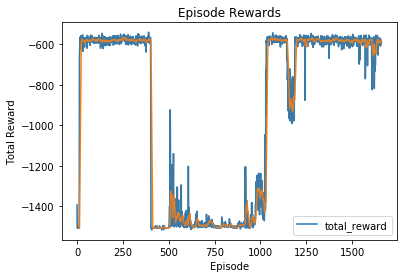

In [7]:
takeoff_stats = pd.read_csv("quad_controller_rl/1_takeoff/takeoff_final_2.csv")
takeoff_stats[['total_reward']].plot(title="Episode Rewards")

reward_array = takeoff_stats.values
eps, rews = reward_array.T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [8]:
# final mean reward over the last 10 episodes
print(smoothed_rews[-1:])

[-586.62093952]


## Task 2: Hover

### Implement hover agent

Now, your agent must take off and hover at the specified set point (say, 10 units above the ground). Same as before, you will need to create an agent and implement the `step()` method (and any other supporting methods) to apply your reinforcement learning algorithm. You may use the same agent as before, if you think your implementation is robust, and try to train it on the new task. But then remember to store your previous model weights/parameters, in case your results were worth keeping.

### States and rewards

Even if you can use the same agent, you will need to create a new task, which will allow you to change the state representation you pass in, how you verify when the episode has ended (the quadcopter needs to hover for at least a few seconds), etc. In this hover task, you may want to pass in the target height as part of the state (otherwise how would the agent know where you want it to go?). You may also need to revisit how rewards are computed. You can do all this in a new task file, e.g. `tasks/hover.py` (remember to follow the steps outlined above to create a new task):

```python
class Hover(BaseTask):
    ...
```


**Q**: Did you change the state representation or reward function? If so, please explain below what worked best for you, and why you chose that scheme. Include short code snippet(s) if needed.

**A**: Yes, I changed the state representation and reward function for this task. First off, Agent needs to maintain the position in place and not to crush into the grounds while trying to keep velocity as close to zero as possible. Therefore state vector includes not only position but also velocity. Also I include the orientation to make agent stay as much upright as possible for stability.

#### - State representation

        position = np.array([pose.position.x, pose.position.y, pose.position.z])
        orientation = np.array([pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w])
        
        if self.last_timestamp is None:
            velocity = np.array([0.0, 0.0, 0.0])
        else:
            velocity = (position - self.last_position) / max(timestamp - self.last_timestamp, 1e-03)

        state = np.concatenate([position, orientation, velocity])
        self.last_timestamp = timestamp
        self.last_position = position

The most important thing for this task was how to define the reward function. I used 3 basic error metrics(position, orientation, veloctiy) to give agent the penalty whenever it made a bad move. Each metrics calculates euclidian distance from the target values and then combines to weighted sum. I've figured out the best weights are 0.55, 0.15, 0.30. Everytime agent takes an action, it gets penalty of this weighted sum. 

#### - Basic reward/penalty

        self.target_position = np.array([0.0, 0.0, 10.0])  # target position to hover at
        self.target_orientation = np.array([0.0, 0.0, 0.0, 1.0])  # target orientation quaternion (upright)  
        self.target_velocity = np.array([0.0, 0.0, 0.0])  # target velocity (ideally should stay in place)
        
        self.weight_position = 0.55 # weight for position error
        self.weight_orientation = 0.15 # weight for orientation error
        self.weight_velocity = 0.30 # weight for velocity error

        # Track the deviations for position, orientation and veloctiy using Euclidian distance.
        error_position = np.linalg.norm(self.target_position - state[0:3]) 
        error_orientation = np.linalg.norm(self.target_orientation - state[3:7])
        error_velocity = np.linalg.norm(self.target_velocity - state[7:10])
        
        reward = -(self.weight_position * error_position + self.weight_orientation * error_orientation 
        + self.weight_velocity * error_velocity)

I also give extra penalty regard to z-axis position and velocity. Because major goal for hovering is to maintain the target height. Moreover What I've found during several iterations is that agent tends to crash into the ground directly to minimize the above basic penalty as soon as an episode starts. 
Therefore extra penalty for z-axis is denfinitely needed, I made a simple formula. If agent want to minimize this penalty, It must take action to go to target height with lower velocity in the z-axis.

$$Penalty = {\Delta{position}}^2 + \Delta{velocity}$$

#### - Extra penalty for z-axis
        z_axis_penalty = (self.target_position[2] - pose.position.z)**2 + abs(self.target_velocity[2]-state[9])
        reward -= z_axis_penalty

I want to end as episode if agent strays too far because hovering on (x,y) space far from target position is unwanted. Thus I give extra penalty to agent if it exceeds maximum distance from target position. Especially when agent just fly away from target position at early timestep, It will get big weighted extra penalty. The weight is calculated by smooth function of exponential and square root (http://www.wolframalpha.com/input/?i=sqrt(exp(x)))&wal=header)

$$Penalty = -50*\sqrt{e^{\Delta{time}}}$$


#### - Extra penalty for straying far from target position

            if error_position > self.max_error_position:
            reward -= 50 * np.sqrt(np.exp(abs(self.max_duration-timestamp)))  # extra penalty, agent strayed too far
            done = True

If agent manages to hover during given period, It means that time step is larger than maximum duration. So I give agent the reward for this case. Finally If agent is in neither of those two cases, It meant that agent is hovering around target position in some way. In that case, agent deserves to get extra reward. This is weighted by how much less it make an error with respect to difference between target poistion and current position. I use the logarithm to make it smooth, hopefully it can reflect agent's action. 

#### - Rewards

        elif timestamp > self.max_duration:
            reward += 100.0  # extra reward, agent made it to the end
            done = True
        else:
            reward += (30.0 * np.log(self.max_error_position - error_position))

### Implementation notes

**Q**: Discuss your implementation below briefly, using the following questions as a guide:

- What algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**A**:

I've used the DDPG algorithm and same network architecture from take-off task. The final choice of learning rates for actor and critic was **0.0001** and **0.001** which was used in the DDPG paper(_Lillicrap, et al. Continuous control with Deep Reinforcement Learning_). I tried to use other hyperparemeters even with a swtich to adagrad optimizers. But so far Adam optimizers for both actor and critic with 0.0001/0.001 worked better. 



Both Actor and Critic network is consists of dense layers. Actor network has 3 hidden dense layers and  Critic has 2 hidden dense layers with 32-64 units each. Because takeoff, hover and landing tasks are relatively simple tasks, I think both networks don't have to be much deeper. Every hidden layers has relu activation functions and is initialized by He uniform variance scaling initializer to flow gradients properly. 

#### - Actor network  arcitecture
        states = layers.Input(shape=(self.state_size,), name='states')

        # Hidden layers
        net = layers.Dense(units=32, activation='relu', kernel_initializer='he_uniform')(states)
        net = layers.Dense(units=64, activation='relu', kernel_initializer='he_uniform')(net)
        net = layers.Dense(units=32, activation='relu', kernel_initializer='he_uniform')(net)

        # Final output layer with sigmoid activation
        raw_actions = layers.Dense(units=self.action_size, activation='sigmoid',
            name='raw_actions', kernel_initializer='he_uniform')(net)

        # Scale [0, 1] output for each action dimension to proper range
        actions = layers.Lambda(lambda x: (x * self.action_range) + self.action_low,
            name='actions')(raw_actions)

Since the actor network for DDPG is deterministic, the activation function of output layer is sigmoid. It generate action vector in range [0,1]. [0,1] might not be the actual range for each action dimension, so it scales to proper range by using lambda function. 

#### - Critic network  arcitecture
        # input layers
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')

        # hidden layer(s) for state pathway
        net_states = layers.Dense(units=32, activation='relu', kernel_initializer='he_uniform')(states)
        net_states = layers.Dense(units=64, activation='relu', kernel_initializer='he_uniform')(net_states)

        # hidden layer(s) for action pathway
        net_actions = layers.Dense(units=32, activation='relu', kernel_initializer='he_uniform')(actions)
        net_actions = layers.Dense(units=64, activation='relu', kernel_initializer='he_uniform')(net_actions)
        
        # Combine state and action pathways
        net = layers.Add()([net_states, net_actions])
        net = layers.Activation('relu')(net)
        
        # final output layer
        Q_values = layers.Dense(units=1, name='q_values', kernel_initializer='he_uniform')(net)

Crtic network has two pathways to get sepearte states and actions, and then each outputs from hidden layers are combined. Final output layer generates Q-value with linear activation function.

And lastly, these are the hyper parameters that have been used for this project. Again those numbers are from the DDPG paper(_Lillicrap, et al. Continuous control with Deep Reinforcement Learning_).

- batch size for replay buffer : _64_
- discount factor $\gamma$ : _0.99_
- soft update parameter $\tau$ : _0.0001_

### Plot episode rewards

As before, plot the episode rewards, either from a single run, or averaged over multiple runs. Comment on any changes in learning behavior.

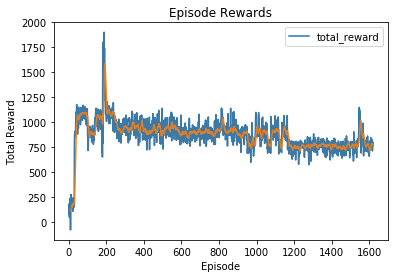

In [4]:
# TODO: Read and plot episode rewards
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 


df_hover_stats = pd.read_csv("quad_controller_rl/2_hover/hover_final.csv")
df_hover_stats[['total_reward']].plot(title="Episode Rewards")


reward_array = df_hover_stats.values
eps, rews = reward_array.T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

At early episode, quadcopter just tends to crash into the ground and sometimes it didn't try to pick up speed upwards. But at 31st episode, agent finally try to maintain the heights and got aha moment. After that episode, graph has many oscilations but in general it seems to converge. It made great performances a few times around 189th episode, but it never get the same rewards. According to my observation, quadcopter still tried to lower down the height but still decent rewards. In my opinion, that is the reason why there are so many oscilations and can not achieve the best rewards again. I think the elaborate reward function can solve this problem.

## Task 3: Landing

What goes up, must come down! But safely!

### Implement landing agent

This time, you will need to edit the starting state of the quadcopter to place it at a position above the ground (at least 10 units). And change the reward function to make the agent learn to settle down _gently_. Again, create a new task for this (e.g. `Landing` in `tasks/landing.py`), and implement the changes. Note that you will have to modify the `reset()` method to return a position in the air, perhaps with some upward velocity to mimic a recent takeoff.

Once you're satisfied with your task definition, create another agent or repurpose an existing one to learn this task. This might be a good chance to try out a different approach or algorithm.

### Initial condition, states and rewards

**Q**: How did you change the initial condition (starting state), state representation and/or reward function? Please explain below what worked best for you, and why you chose that scheme. Were you able to build in a reward mechanism for landing gently?

**A**: Since landing task is similar to take-off task, I adopt the same action space and state space. But the agent starts at certain height and has to move downwards before grounds, I need to reconfigure the Initial condition for this behavior. 

I set up the target position (x,y,z) as [0.0, 0.0, 0.1]. The reason why z-position is 0.1 instead of 0.0 is that quadcopter has its own thickness, so it can't reach to 0.0. Therefore target height should be 0.1.

The initial position(z-axis) is set as 13.0. When initial elevation is too low, It looks like agent has hard time to adjust its forces and velocity. In my opinion, larger number may give agent some room to learn how to adjust those things and explore many cases in general. Therefore Initial condition is set as follows with a tiny bit of randomness.

#### - Initial Condition
        # start height
        self.start_position = 13.0 
        
        # Initial condition
        Pose(position=Point(0.0, 0.0, self.start_position + np.random.normal(0.5, 0.1)), # slight random position around the target
            orientation=Quaternion(0.0, 0.0, 0.0, 1.0),), 
            Twist(linear=Vector3(0.0, 0.0, 0.0), angular=Vector3(0.0, 0.0, 0.0))

Because quadcopter is expected to land gently and not to make some jolty movements, Velocity should not be changed dramatically. Since change of the velocity is related to the acceleration, I need to  make agent concern about linear accelerations. So I set linear acceleration as one of state vector elements.

#### - State vector
        position = np.array([pose.position.x, pose.position.y, pose.position.z])
        orientation = np.array([pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w])
        acceleration = np.array([linear_acceleration.x, linear_acceleration.y, linear_acceleration.z])

        if self.last_timestamp is None:
            velocity = np.array([0.0, 0.0, 0.0])
        else:
            velocity = (position - self.last_position) / max(timestamp - self.last_timestamp, 1e-03) # prevent divide by zero
        
        state = np.concatenate([position, orientation, velocity, acceleration]) # combined state vector

I give agent a basic penalty with the euclidean distance between target position and current position. This is for insurance to make agent comedown to ground and not far from target position on (x,y) space. 

#### - Basic penalty
        error_position = np.linalg.norm(self.target_position - state[0:3])
        reward = -error_position

I think that the penalty with respect to z-axis could be useful along with hover task. But unlike hover task, Both z-position and velocity 
should be close to 0 when it is close to the ground. However agent needs to pick up speed downwards in the beginning of an episode. To solve this problem, First I clipped each error to scale to different ranges. Especially the range for velocity is clipped to [-20.0, 20.0]. This means quadcopter could pickup speed downwards exceding -20.0 since np.clip(-25, -20.0, 20.0) = -20. Therefore agent might get early-thrust to push down to ground. But If agent wants to get maximum reward, It needs to lower the velocity as the z-position is close to the ground. I also added the weight for velocty because It looked like agent accelerates velocity too much.

#### - Extra reward/penalty on z-axis position and velocity
        position_z = np.clip(pose.position.z, 0, 20)**2
        velocity_z = np.clip(state[9],-20, 20)**2
        reward = 20 -np.sqrt(position_z + self.velocity_z_weight*velocity_z)

The sphere equation in three-dimensional space gave me the intuition for this formula. Becuase both lower position and velocity gives higher rewards, I've used this formula naively and It didn't work out well. That's why I made some tweaks and used the above formula.

$ reward^2 + position^2 + velocity^2 = C^2$

$ reward = \sqrt{C^2 - position^2 - velocity^2}$


![sphere](images/sphere.png)

After several trials, It looked like agent dind't learn landing but instead it was trying to learn hovering in the air. My speculation was that because of the extra penalty for z-axis velocity, It seems agent just chose to maintain the height so it could get relativelty less penalty. Thus I give extra for just straying around (x,y) space.

#### - Extra penalty for (x,y) space deviation
        error_position_xy = self.stray_error_weight * np.linalg.norm(self.target_xy - state[0:2])
        reward -= error_position_xy

As mentioned above acceleration sholud be low to make agent move gently. So I give extra penlaty if agent try to do unstable landing by driving up the acceleration.

#### - Aceeleration penalty
        error_acceleration = self.accel_error_weight * np.linalg.norm(self.target_accel - state[10:13])
        reward -= error_acceleration

If agent lands to the target position then it will get bonus rewards. Also If it has run out of time, It will get a penalty.

#### - success or fail situations
        if pose.position.z <= self.target_z:
            reward += 50.0
            done = True
        elif timestamp > self.max_duration: # agent has run out of time
            reward -= 35.0 # penalty
            done = True

Lastly, Reward clipping was introduced for stable learning. Because this avoids instability in training due to exploding gradients.

#### - Reward clipping
        reward = np.clip(reward, -1.0, 1.0)

### Implementation notes

**Q**: Discuss your implementation below briefly, using the same questions as before to guide you.

**A**: Basically I used same network architecture from takeoff and hover tasks. As mentioned before, Actor network has 3 hidden dense layers and Critic has 2 hidden dense layers with 32-64 units. Every hidden layers has relu activation functions and is initialized by He uniform initializer.I've tried to change learning rates and optimizers such as adam and adagrad. In the end I got the best result by using adam optimizers with 0.0001/0.001 for actor and critic. other hyper parameters(tau, gamma, etc) are same as before.

### Plot episode rewards

As before, plot the episode rewards, either from a single run, or averaged over multiple runs. This task is a little different from the previous ones, since you're starting in the air. Was it harder to learn? Why/why not?

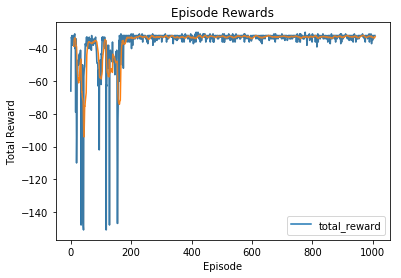

In [9]:
# TODO: Read and plot episode rewards
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

#df_stats = pd.read_csv("../out/stats_2018-03-04_21-18-23.csv")

df_landing_stats = pd.read_csv("quad_controller_rl/3_landing/landing_last.csv")
df_landing_stats[['total_reward']].plot(title="Episode Rewards")


reward_array = df_landing_stats.values
eps, rews = reward_array.T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

It is harder to learn compared to take-off and hover tasks because it is more complicated to design reward/penalty functions than those two. Sometimes quadcopter tried to control its propellers consistently, but in some cases it just flew away or crashed into the grounds. 
It seems that agent was confused what is the best actions.

## Task 4: Combined

In order to design a complete flying system, you will need to incorporate all these basic behaviors into a single agent.

### Setup end-to-end task

The end-to-end task we are considering here is simply to takeoff, hover in-place for some duration, and then land. Time to create another task! But think about how you might go about it. Should it be one meta-task that activates appropriate sub-tasks, one at a time? Or would a single combined task with something like waypoints be easier to implement? There is no right or wrong way here - experiment and find out what works best (and then come back to answer the following).

**Q**: What setup did you ultimately go with for this combined task? Explain briefly.

**A**:

### Implement combined agent

Using your end-to-end task, implement the combined agent so that it learns to takeoff (at least 10 units above ground), hover (again, at least 10 units above ground), and gently come back to ground level.

### Combination scheme and implementation notes

Just like the task itself, it's up to you whether you want to train three separate (sub-)agents, or a single agent for the complete end-to-end task.

**Q**: What did you end up doing? What challenges did you face, and how did you resolve them? Discuss any other implementation notes below.

**A**:

### Plot episode rewards

As before, plot the episode rewards, either from a single run, or averaged over multiple runs.

In [ ]:
# TODO: Read and plot episode rewards

## Reflections

**Q**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, running ROS, plotting, specific task, etc.)
- How did you approach each task and choose an appropriate algorithm/implementation for it?
- Did you find anything interesting in how the quadcopter or your agent behaved?

**A**: The hardest part of this project for me was adjusting reward functions and hyper parameters. Since I need to run many episodes to find out how well my scheme works, Wrong choice of parameters and bad implementation could lead to waste lots of times. It's definitely time consuming project. Set up and running ROS was not hard thing thanks to the udacity instructions. 
 
The only candidate algorithm for agent is DDPG to my knowledge, so I have to implement the DDPG algorithm naturally. However I try to find better results by changing learning rates and optimizers. The one thing I realized is that different combination of optimizer and learning rates will generates different reward plots.  

How to define and specify the reward/penalty function within each tasks was very important. I've used smooth function such as logarithm and square root as much as possible to make consecutive actions not vary wildly. Also I've tested with different weight and reward funtions for at least 500 episodes. If agents didn't make any progress, I made some tweaks or adjusted the weights.

The interesting thing was that if reward function is not elaborate then agent could learn wrong behaviors. During hover task, sometimes agent kept landing to the grounds, and vice versa. Also even if agent did almost perfect landings, It gets less rewards than clumsy landings. This observations convince that reward/penalty function should be implemented well. 

Lastly I think that I focused too much on reward functions in general. There are more room for improving actor and critic networks. For example, I could have used deeper layer for landing task since it is more complicated than others. Also Adding bactch Normalization and regularizations might contribute to better results. 